# Exercise 03

## Setting up your python environment

Before tackling pytorch and the coding exercises, we need to setup our environment first. We require quite a few different python modules throughout these exercises. Depending on whether you use `google colab` or work locally, the setup looks a bit different. As `google colab` does not support `conda` natively, we give you instructions for installing all the packages with `pip`. These instructions are repeated in each exercise script if necessary. However, we still recommend you to try it here. For a local python environment, we recommend you to use conda as installing torch via `pip` is quite tricky.

### Google Colab - pip instructions

Google colab comes with a pre-installed python version (currently `3.10.12` as of the creation of these exercises) and some pre-installed packages such as *numpy*, *pandas*, *pytorch*, etc., which is already quite handy. To install the rest of the required packages, you can easily just run the code cell below. The code cell does the following:
- mount your google drive onto your colab
- set the working directory to be the `cv2mvg` folder
- install all packages via `pip install -r requirements.txt`

In [5]:
use_colab = False
if use_colab:
    from google.colab import drive
    import os

    gdrive_path='/content/gdrive/MyDrive/cv2mvg_exercise_code'

    # This will mount your google drive under 'MyDrive'
    drive.mount('/content/gdrive', force_remount=True)
    # In order to access the files in this notebook we have to navigate to the correct folder
    os.chdir(gdrive_path)
    # Check manually if all files are present
    print(sorted(os.listdir()))
    !pip install -r requirements.txt
dataset_path = '../datasets/exercise_03'

### Local install - conda

To install the environment with conda you just have to change your working directory to the `cv2mvg` folder and run
```
conda env create -f environment.yaml
```


### Checking the environment
Run the following code cell to check if relevant packages were installed.

In [2]:
try:
    import cv2
except:
    !pip install opencv-python
    import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/d1/2c/285651e5dbdbd197234c9d000af710f128bce6f851213ec503e399b8f6c0/opencv_python-4.10.0.82-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 10.1 MB/s eta 0:00:0000:0100:01


In [3]:
from exercise_code import getM, getq, getHarrisCorners, getFlow, drawPoints, getGradients, getTemporalPartialDerivative
from tests import test_flow_absolute, test_flow_angular, test_flow_computation_time, test_flow_endpoint
%load_ext autoreload
%autoreload 2

In [9]:
# wget the optical flow dataset
import os
os.makedirs(dataset_path, exist_ok=True)
if not os.path.exists(dataset_path+'/other-color-allframes.zip'):
    !wget https://vision.middlebury.edu/flow/data/comp/zip/other-color-allframes.zip --directory-prefix={dataset_path}/
    !unzip {dataset_path}/other-color-allframes.zip -d {dataset_path}/

    !wget https://vision.middlebury.edu/flow/data/comp/zip/other-gt-flow.zip --directory-prefix={dataset_path}/
    !unzip {dataset_path}/other-gt-flow.zip -d {dataset_path}/


--2024-06-08 19:41:27--  https://vision.middlebury.edu/flow/data/comp/zip/other-color-allframes.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33671986 (32M) [application/zip]
Saving to: ‘../datasets/exercise_03/other-color-allframes.zip’

other-color-allfram 100%[===================>]  32,11M  3,87MB/s    in 7,7s    

2024-06-08 19:41:35 (4,19 MB/s) - ‘../datasets/exercise_03/other-color-allframes.zip’ saved [33671986/33671986]

Archive:  ../datasets/exercise_03/other-color-allframes.zip
  inflating: ../datasets/exercise_03/other-data/Beanbags/frame07.png  
  inflating: ../datasets/exercise_03/other-data/Beanbags/frame08.png  
  inflating: ../datasets/exercise_03/other-data/Beanbags/frame09.png  
  inflating: ../datasets/exercise_03/other-data/Beanbags/frame10.png  
  inflating: ../datasets/exercise_03/other-d

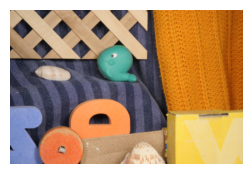

In [10]:
# Load the original image
im1 = Image.open(dataset_path+'/other-data/RubberWhale/frame10.png')
im1 = np.array(im1)

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.imshow(im1)

## Part I: Structure Tensor

In order to be able to detect corners in an image and compute optical flow, the structure tensor $M$ shall be computed in this exercise.

At first compute the image gradients $I_x$ and $I_y$ using central differences.
- Go to ```getGradients``` in ```exercise_code/utils.py``` and fill in the missing lines of code.

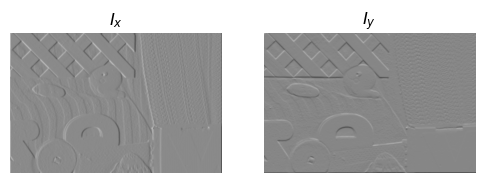

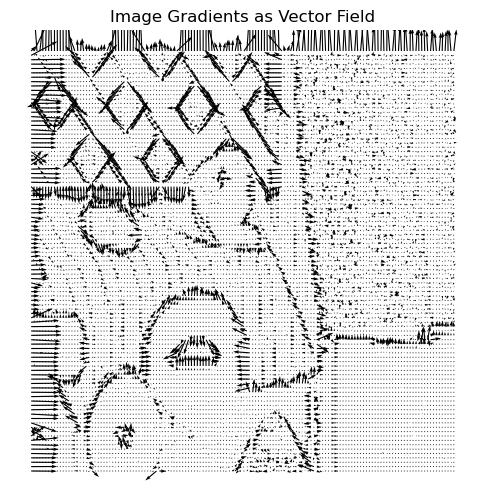

In [12]:
im1 = Image.open(dataset_path+'/other-data/RubberWhale/frame10.png')
# convert to grayscale
im1 = im1.convert('L')
im1 = np.array(im1)

# get image gradients
Ix, Iy = getGradients(im1, sigma=1)

# show image gradients
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(Ix, cmap='gray')
plt.title('$I_x$')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Iy, cmap='gray')
plt.title('$I_y$')
plt.axis('off')
# show image gradients by vector field
plt.figure(figsize=(6,6))
X = np.arange(0, Ix.shape[1], 1)
Y = np.arange(0, Ix.shape[0], 1)

# plot every 4th vector to avoid clutter
d = 4
q = plt.quiver(X[::d],Y[::d],Ix[::d,::d],Iy[::d,::d])
plt.axis('off')
plt.title('Image Gradients as Vector Field')
ax = plt.gca()
ax.invert_yaxis()


Now write a function that computes the entries of the structure tensor $M$ (see Theory, Ex.1(a)) for every pixel $(x,y)$ of an image $I$. 

-  As weighting function use a two-dimensional Gaussian Kernel with a standard deviation $\sigma$ (see Theory, Ex.1(a)). Use a kernel size (and hence integration window size) $k = 4\sigma+1$. Go to ```getGaussiankernel``` in ```exercise_code/utils.py``` and fill in the missing lines of code to compute the kernel $G$.

- Compute the structure tensor using a weighting function $G$ to compute the structure tensor $M$, i.e. a $2 \times 2$ matrix for each Pixel.  Why is it not necessary to compute $m_{21}$? Go to ```getM``` in ```exercise_code/utils.py```and fill in the missing lines of code.

In [13]:
# get structure tensor
M = getM(Ix, Iy, sigma=1)

## Part II: Corner Detection

Now let us compute some intereset points which we want to track.
In this exercise you will implement the Harris corner detector. Go to ```getHarrisCorners``` in ```exercise_code/getHarrisCorners.py``` and fill in the missing lines of code using the following method:

- Compute the scoring function $C := \text{det}(M) - \kappa \text{ trace}^2(M)$ for each pixel $(x,y)$.
- Find all pixels $(x,y)$ for which $C(x,y) > \theta$, and which are a local maximum of the scoring function, i.e. all four adjacent pixel have a lower score.

In [ ]:
k = 0.05 # k for Harris corner detection
t = 1e-2 # threshold for Harris corner detection

score, points = getHarrisCorners(M, k, t)

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)

im1_ = drawPoints(im1.copy(), points.T)
plt.imshow(im1_)

## Part III: Optical Flow

In this exercise you will implement the Lucas-Kanade method to compute optical flow.
But first check the ground truth data as a reference.

In [ ]:
# save a gif of the two images
im1 = Image.open(dataset_path+'/other-data/RubberWhale/frame10.png')
im2 = Image.open(dataset_path+'/other-data/RubberWhale/frame11.png')
# overwrite the gif file

im1.save(dataset_path+'/img.gif', save_all=True, append_images=[im2], duration=1000, loop=0)
# show the gif
from IPython.display import Image as IPImage
IPImage(filename=dataset_path+'/img.gif')


In [ ]:
flow = cv2.readOpticalFlow(dataset_path+'/other-gt-flow/RubberWhale/flow10.flo')

mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
mag[mag>2357022699]=0
hsv = np.zeros_like(im1)
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 2] = 255
hsv[..., 2] = cv2.normalize(mag, None, 100, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(bgr)
plt.axis('off')
plt.title('Ground Truth Optical Flow')
plt.subplot(1, 2, 2)
# read the image
im_hsv = Image.open('hsv.jpg')
plt.axis('off')
plt.imshow(im_hsv)

In [ ]:
im1_gray = im1.convert('L')
im2_gray = im2.convert('L')

im1_gray = np.array(im1_gray)
im2_gray = np.array(im2_gray)

### OpenCV Lukas Kanade Implementation

As a reference you can checkout the openCV implementation of the Lukas Kanade optical flow.
You can already see that it can capture the direction of movement quite accurately.

In [ ]:
# get dense points for flow
x = np.arange(0, im1_gray.shape[0], 1)
y = np.arange(0, im1_gray.shape[1], 1)
x, y = np.meshgrid(x, y)
p0 = np.array([y.flatten(), x.flatten()]).T # opencv uses different order
p0 = p0[:,None,:].astype(np.float32)
lk_params = dict( winSize = (15, 15),
 maxLevel = 0,
 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
p1, st, err = cv2.calcOpticalFlowPyrLK(im1_gray, im2_gray, p0, None, **lk_params)

# Select good points
good_new = p1[st==1]
good_old = p0[st==1]

flow_lk = np.zeros((im1_gray.shape[0], im1_gray.shape[1], 2))
# fill in the flow
for i in range(len(good_new)):
    try:
        flow_lk[int(good_old[i][1]), int(good_old[i][0])] = good_new[i] - good_old[i] # opencv uses different order
    except:
        pass

In [ ]:
mag, ang = cv2.cartToPolar(flow_lk[...,0], flow_lk[...,1])
hsv = np.zeros_like(im1)
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 2] = 255
hsv[..., 2] = cv2.normalize(mag, None, 100, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(bgr)
plt.axis('off')
plt.title('Lukas Kanade Optical Flow')
plt.subplot(1, 2, 2)
# read the image
im_hsv = Image.open('hsv.jpg')
plt.axis('off')
plt.imshow(im_hsv)

### Your Lukas Kanade implementation
Now let's start with our own implementation:
- Write a function that computes the vector $I_t$ for every pixel $(x,y)$. Go to ```getTemporalPartialDerivative``` in ```exercise_code/utils.py```and fill in the missing lines of code.
- Write a function that computes the vector $\mathbf{q}$ for every pixel $(x,y)$. Go to ```getq``` in ```exercise_code/utils.py```and fill in the missing lines of code.
- Write a function that computes the local velocity $(\hat{v}_x,\hat{v}_y)$ at the input points using the formula derived in theory. Go to ```getFlow``` in ```exercise_code/getFlow.py```and fill in the missing lines of code.
- Try different values for $\sigma$. What do you observe?


In [ ]:
sigma_gradient = 0
sigma = 7
It = getTemporalPartialDerivative(im1_gray, im2_gray, sigma=sigma_gradient)
Ix, Iy = getGradients(im1_gray, sigma=sigma_gradient)
q = getq(It, Ix, Iy, sigma=sigma)
print(q.shape)
M = getM(Ix, Iy, sigma=sigma)
print(M.shape)

Now lets compute the flow.

In [ ]:
# get dense points for flow
x = np.arange(0, im1_gray.shape[0], 1)
y = np.arange(0, im1_gray.shape[1], 1)
x, y = np.meshgrid(x, y)
points = np.array([x.flatten(), y.flatten()]).T
flow_lk,flow_lk_points = getFlow(M, q, points)

Visualize the flow

In [ ]:
mag, ang = cv2.cartToPolar(flow_lk[...,0], flow_lk[...,1])
hsv = np.zeros_like(im1)
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 2] = 255
hsv[..., 2] = cv2.normalize(mag, None, 100, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(bgr)
plt.axis('off')
plt.title('Lukas Kanade Optical Flow')
plt.subplot(1, 2, 2)
# read the image
im_hsv = Image.open('hsv.jpg')
plt.axis('off')
plt.imshow(im_hsv)

## Test your method
Here, you can test your method locally. If you want to compare your method to the implementations of other students, you can submit the code on the test server.
There will be a leaderboard showing the best optical flow algorithm on the top.
For the final submission, please set the default values in your function already.
We will not pass any parameters (like $\sigma$) for evaluation.

If you want to checkout the worldwide leaderboard, you can follow this link:
[Middlebury Evaluation](https://vision.middlebury.edu/flow/eval/)


In [ ]:
score = test_flow_angular(dataset_path) # cosine similarity of normalized vectors [-1,1] (the higher the better)
score = test_flow_absolute(dataset_path) # mse of vector length [0, inf] (the lower the better)
score = test_flow_computation_time(dataset_path) # time in seconds [0, inf] (the lower the better)
score = test_flow_endpoint(dataset_path) # mse of endpoint [0, inf] (the lower the better)

These are the results obtained from the opencv implementation of the highly optimized OpenCV Lukas Kanade Tracker as a reference.


![](opencv_eval.png)

In [ ]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise03')